In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
from craterdetection.deepmoon import DeepMoon, template_match_t
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [11]:
R = 1737.1 #km

moon = ccrs.Globe(
    semimajor_axis=R*1000,
    semiminor_axis=R*1000,
    ellipse=None
)

geodetic = ccrs.Geodetic(globe=moon)
plate_proj = ccrs.PlateCarree(globe=moon)
ortho_proj = ccrs.Orthographic(globe=moon)

In [165]:
import pandas as pd

df_craters  = pd.read_csv("../data/lunar_crater_database_robbins_2018.csv", usecols=['CRATER_ID', 'LAT_ELLI_IMG', 'LON_ELLI_IMG', 'DIAM_CIRC_IMG'])
df_craters

,CRATER_ID,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG
0,00-1-000000,-19.89050,264.6650,940.96000
1,00-1-000001,44.40830,329.0460,249.84000
2,00-1-000002,56.90000,81.6464,599.77800
3,00-1-000003,1.95072,230.5880,558.76200
4,00-1-000004,-49.18330,266.3530,654.33200
...,...,...,...,...
1296791,10-2-014997,-65.62160,203.5380,5.93636
1296792,10-3-000000,-60.03010,178.7120,7.82310
1296793,10-3-000003,-66.79510,219.3470,11.55320
1296794,10-3-000004,-79.84080,62.1830,7.16411


In [169]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Image metadata
img = cv2.imread('../data/scr00022.jpg', cv2.IMREAD_GRAYSCALE)
latitude = "1-0-0.0N"
longitude = "175-0-0.0E"

##assuming N latitude and W longitude
latitude = sum(float(x) / 60 ** n for n, x in enumerate(latitude[:-1].split('-')))  * (1 if 'N' in latitude[-1] else -1)
longitude = sum(float(x) / 60 ** n for n, x in enumerate(longitude[:-1].split('-'))) * (1 if 'E' in longitude[-1] else -1)
longitude = (360 + longitude) if longitude < 0 else longitude

h = 211 #km
fov = 45 #degrees (vertical FOV uncropped image)

# Crop center of screenshot to input shape 
ysize, xsize = img.shape
x_in, y_in = (1080, 1080)
img = img[(ysize//2)-(y_in//2):(ysize//2)+(y_in//2), (xsize//2)-(x_in//2):(xsize//2)+(x_in//2)]

# Image dimension
d = 2*(y_in/ysize)*h*np.tan(np.deg2rad(fov/2)) 
fov_crop = np.rad2deg(np.arctan(d/h))
R = 1737.4
circ = 2*np.pi*R
d_angle = (d/circ)*360
lat_min, lat_max = (latitude - (d_angle/2), latitude + (d_angle/2))
long_min, long_max = (longitude - (d_angle/2), longitude + (d_angle/2))
((long_min, long_max), (lat_min, lat_max))

((172.11776368909688, 177.88223631090312),
 (-1.8822363109031164, 3.8822363109031164))

In [170]:
df_close = df_craters.query("(LON_ELLI_IMG < @long_max) & (LON_ELLI_IMG > @long_min)")
df_close = df_close.query("(LAT_ELLI_IMG < @lat_max) & (LAT_ELLI_IMG > @lat_min)")
df_close

,CRATER_ID,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG
834538,08-1-002301,1.047510,173.698,10.96370
834539,08-1-002302,1.813410,173.491,8.66433
834540,08-1-002303,1.875370,173.217,17.71590
834543,08-1-002306,3.574150,173.206,18.82340
834544,08-1-002307,3.625820,172.706,10.11030
...,...,...,...,...
1175994,09-3-000283,-0.360151,175.895,1.32799
1175995,09-3-000286,-0.418822,176.081,1.61292
1175996,09-3-000291,-0.302092,175.645,2.76087
1175997,09-3-000293,-0.248940,175.231,1.13672


In [171]:
df_close.eval('long_pix = ((LON_ELLI_IMG - @long_min) / @d_angle) * @x_in', inplace=True)
df_close.eval('lat_pix = ((LAT_ELLI_IMG - @lat_min) / @d_angle) * @y_in', inplace=True)
df_close

,CRATER_ID,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,long_pix,lat_pix
834538,08-1-002301,1.047510,173.698,10.96370,296.064415,548.901213
834539,08-1-002302,1.813410,173.491,8.66433,257.282030,692.396040
834540,08-1-002303,1.875370,173.217,17.71590,205.946891,704.004526
834543,08-1-002306,3.574150,173.206,18.82340,203.885991,1022.278637
834544,08-1-002307,3.625820,172.706,10.11030,110.208732,1031.959245
...,...,...,...,...,...,...
1175994,09-3-000283,-0.360151,175.895,1.32799,707.682295,285.169563
1175995,09-3-000286,-0.418822,176.081,1.61292,742.530236,274.177285
1175996,09-3-000291,-0.302092,175.645,2.76087,660.843665,296.047179
1175997,09-3-000293,-0.248940,175.231,1.13672,583.278894,306.005446


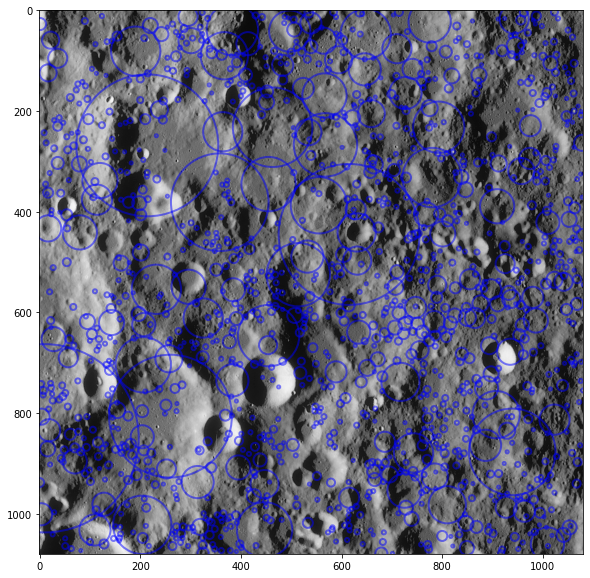

In [172]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.imshow(img, cmap='Greys_r')

for r in df_close.iterrows():
    row = r[1]
    x, y = (round(row['long_pix']), round(row['lat_pix']))
    radius = round(((row['DIAM_CIRC_IMG']/d)/2)*x_in)
    circle = plt.Circle((x, y), radius, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes.add_artist(circle)